# Drought Classification Workflow

This notebook demonstrates the drought classification workflow for the Snow Drought Index package. It covers loading SSWEI data, classifying drought conditions, analyzing drought characteristics, and visualizing drought patterns over time.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from pathlib import Path
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation, sswei, drought_classification
from snowdroughtindex.utils import visualization, io

## 1. Load SWE and Precipitation Data

First, we'll load the SWE and precipitation data that are used to classify snow drought explained in Heldmyer et al. CaSR v3.1 data are used in this workflow. onset_to_peak.csv dataset created in 0.3_CaSE_dat_preparation is used here. The dataset consists of SWE and precipitation data extracted from onset (day with 5% of climatological mean SWE) to peak SWE day extracted for the each grid point inside the River Basin.

In [2]:
# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

In [3]:
# Paths for input and output data
CaSR_path = project_root / 'data' / 'output_data' / 'modelled_data_snowdrought' / 'onset_to_peak_data.csv'
peak_SWE_path = project_root / 'data' / 'output_data' / 'modelled_data_snowdrought' / 'peak_SWE_by_elev.csv'
Bow_basin_path = project_root / 'data' / 'input_data' / 'Elevstion' / 'Bow_elevation_combined.shp'
output_data = project_root / 'data' / 'output_data' / 'Heldmyer_method'
output_plots = project_root / 'data' / 'output_plots' / 'Heldmyer_method'


In [4]:
# Load SSWEI data from CSV file
onset_to_peak_csv = pd.read_csv(CaSR_path)

# Display the first few rows of the data
onset_to_peak_csv.head()

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change
0,1981-02-11,1,-116.13797,51.33459,152.250,0.000000,2000_2500m,1980,0.570312
1,1980-11-07,1,-116.13797,51.33459,27.000,2.128011,2000_2500m,1980,0.000000
2,1980-12-21,1,-116.13797,51.33459,110.625,3.271602,2000_2500m,1980,0.000000
3,1980-10-25,1,-116.13797,51.33459,12.625,0.000000,2000_2500m,1980,27.875000
4,1980-11-13,1,-116.13797,51.33459,40.500,0.007695,2000_2500m,1980,13.000000


# 2. Find 30 year climatological mean peak SWE for each elevation level

In [5]:
# Load the peak SWE data
peak_SWE_data = pd.read_csv(peak_SWE_path)

# Display the first few rows of the peak SWE data
peak_SWE_data.head()

,Year,peak_1000_1500m,peak_1500_2000m,peak_2000_2500m,peak_500_1000m
0,1981,24.797070,44.364788,154.827127,28.219308
1,1982,26.354167,44.508929,161.058333,40.208705
2,1983,30.337500,38.036621,161.275000,46.500000
3,1984,28.929175,33.191089,130.524913,34.360491
4,1985,17.887549,36.879576,142.178972,55.231249


In [6]:
# Melt the DataFrame to long format for elevation bands
peak_SWE_long = peak_SWE_data.melt(id_vars='Year', 
								   value_vars=[col for col in peak_SWE_data.columns if col.startswith('peak_')],
								   var_name='elevation', 
								   value_name='peak_SWE')

# Calculate mean peak SWE for each elevation band
mean_peak_SWE = peak_SWE_long.groupby('elevation')['peak_SWE'].mean().reset_index()
mean_peak_SWE.columns = ['elevation', 'mean_peak_SWE']

# rename the elevation column to match the format in the CaSR data
mean_peak_SWE['elevation'] = mean_peak_SWE['elevation'].str.replace('peak_', '', regex=True)


# Display the first few rows of the mean peak SWE data
mean_peak_SWE.head()

,elevation,mean_peak_SWE
0,1000_1500m,31.683571
1,1500_2000m,42.490168
2,2000_2500m,146.697722
3,500_1000m,42.381356


## 3. Identify Snow Drought years

The snow drought are defined as years with peak SWE < climatological peak SWE.

In [7]:
# Calculate cumulative precipitation for each season year and grid point
onset_to_peak_csv['cumulative_P'] = onset_to_peak_csv.groupby(['Season_year', 'Grid_id'])['Precipitation'].cumsum()

# Group by Season_year and Grid_id to get max cumulative_P and mean_SWE
onset_to_peak_mean = onset_to_peak_csv.groupby(['Season_year', 'Grid_id', 'Elevation_Category']).agg(
	mean_SWE=('daily_SWE_change', 'mean'),
	max_cumulative_P=('cumulative_P', 'max'),
    peak_SWE =('SWE', 'max')
).reset_index()


display(onset_to_peak_mean)

,Season_year,Grid_id,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE
0,1980,1,2000_2500m,40.583472,300.622847,240.625000
1,1980,2,2000_2500m,52.081269,315.680771,303.687500
2,1980,3,2000_2500m,35.948574,369.791102,285.125000
3,1980,4,2000_2500m,27.977563,267.465768,173.750000
4,1980,5,2000_2500m,40.056669,258.812712,214.259770
...,...,...,...,...,...,...
11046,2022,253,500_1000m,1.424310,43.924750,21.625000
11047,2022,254,500_1000m,0.760420,103.277450,21.513672
11048,2022,255,500_1000m,0.596191,44.439854,18.750000
11049,2022,256,500_1000m,0.222141,48.831698,20.875000


In [8]:
# Check for points where mean_SWE > mean_cumulative_P in onset_to_peak_mean_all
mean_swe_gt_cumP = onset_to_peak_mean[onset_to_peak_mean['mean_SWE'] > onset_to_peak_mean['max_cumulative_P']]
print(f"Number of points with mean_SWE > mean_cumulative_P: {len(mean_swe_gt_cumP)}")
display(mean_swe_gt_cumP)

Number of points with mean_SWE > mean_cumulative_P: 29


,Season_year,Grid_id,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE
1648,1986,107,1500_2000m,19.004557,12.073696,58.125
1956,1987,158,500_1000m,14.339924,9.588938,66.500
1957,1987,159,500_1000m,13.551666,10.051811,50.875
1958,1987,160,500_1000m,14.359484,10.077503,77.000
1959,1987,161,500_1000m,14.158924,11.193862,83.375
1962,1987,164,500_1000m,16.390390,13.670831,94.125
1963,1987,165,500_1000m,17.319447,11.891097,91.375
2004,1987,206,500_1000m,22.860563,21.991155,62.750
2023,1987,225,500_1000m,3.037886,1.322648,14.125
2049,1987,251,500_1000m,25.491346,18.073842,74.125


In [9]:
# Remove points where mean_SWE > max_cumulative_P from onset_to_peak_mean
onset_to_peak_mean_filtered = onset_to_peak_mean[~onset_to_peak_mean.index.isin(mean_swe_gt_cumP.index)]

# Display the filtered DataFrame
display(onset_to_peak_mean_filtered)

,Season_year,Grid_id,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE
0,1980,1,2000_2500m,40.583472,300.622847,240.625000
1,1980,2,2000_2500m,52.081269,315.680771,303.687500
2,1980,3,2000_2500m,35.948574,369.791102,285.125000
3,1980,4,2000_2500m,27.977563,267.465768,173.750000
4,1980,5,2000_2500m,40.056669,258.812712,214.259770
...,...,...,...,...,...,...
11046,2022,253,500_1000m,1.424310,43.924750,21.625000
11047,2022,254,500_1000m,0.760420,103.277450,21.513672
11048,2022,255,500_1000m,0.596191,44.439854,18.750000
11049,2022,256,500_1000m,0.222141,48.831698,20.875000


In [10]:
# Calculate mean max_cumulative_P for each elevation category (across all grid points)
mean_cumP_by_elev = onset_to_peak_mean_filtered.groupby('Elevation_Category')['max_cumulative_P'].mean().reset_index()
mean_cumP_by_elev = mean_cumP_by_elev.rename(columns={'max_cumulative_P': 'mean_max_cumulative_P'})

display(mean_cumP_by_elev)

,Elevation_Category,mean_max_cumulative_P
0,1000_1500m,78.205260
1,1500_2000m,136.692334
2,2000_2500m,233.064117
3,500_1000m,57.124399


In [11]:
# Merge the mean back to the main DataFrame
onset_to_peak_mean_filtered = onset_to_peak_mean_filtered.merge(
    mean_cumP_by_elev,
    on='Elevation_Category',
    how='left'
)

display(onset_to_peak_mean_filtered)

,Season_year,Grid_id,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE,mean_max_cumulative_P
0,1980,1,2000_2500m,40.583472,300.622847,240.625000,233.064117
1,1980,2,2000_2500m,52.081269,315.680771,303.687500,233.064117
2,1980,3,2000_2500m,35.948574,369.791102,285.125000,233.064117
3,1980,4,2000_2500m,27.977563,267.465768,173.750000,233.064117
4,1980,5,2000_2500m,40.056669,258.812712,214.259770,233.064117
...,...,...,...,...,...,...,...
11017,2022,253,500_1000m,1.424310,43.924750,21.625000,57.124399
11018,2022,254,500_1000m,0.760420,103.277450,21.513672,57.124399
11019,2022,255,500_1000m,0.596191,44.439854,18.750000,57.124399
11020,2022,256,500_1000m,0.222141,48.831698,20.875000,57.124399


In [12]:
# Merge mean_peak_SWE to onset_to_peak_mean_filtered for each elevation category
onset_to_peak_mean_filtered = onset_to_peak_mean_filtered.merge(
    mean_peak_SWE[['elevation', 'mean_peak_SWE']],
    left_on='Elevation_Category',
    right_on='elevation',
    how='left'
)

# Drop the redundant 'elevation' column after merge
onset_to_peak_mean_filtered = onset_to_peak_mean_filtered.drop(columns=['elevation'])

display(onset_to_peak_mean_filtered.head())

,Season_year,Grid_id,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE,mean_max_cumulative_P,mean_peak_SWE
0,1980,1,2000_2500m,40.583472,300.622847,240.62500,233.064117,146.697722
1,1980,2,2000_2500m,52.081269,315.680771,303.68750,233.064117,146.697722
2,1980,3,2000_2500m,35.948574,369.791102,285.12500,233.064117,146.697722
3,1980,4,2000_2500m,27.977563,267.465768,173.75000,233.064117,146.697722
4,1980,5,2000_2500m,40.056669,258.812712,214.25977,233.064117,146.697722


In [13]:
# Initialize an empty DataFrame to store the results
onset_to_peak_mean_all = pd.DataFrame()
# Iterate through each coordinate_id
for Grid_id in onset_to_peak_mean_filtered['Grid_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = onset_to_peak_mean_filtered[onset_to_peak_mean_filtered['Grid_id'] == Grid_id]
    # calculate cumulative P anomaly
    # Calculate mean max_cumulative_P for each elevation category
    # Calculate anomaly
    onset_to_peak_mean_filtered['cumulative_P_anomaly'] = (
        onset_to_peak_mean_filtered['max_cumulative_P'] - onset_to_peak_mean_filtered['mean_max_cumulative_P']
    )
    # Calculate mean_SWE/max_cumulative_P ratio
    onset_to_peak_mean_filtered['mean_SWE/max_cumulative_P'] = onset_to_peak_mean_filtered['mean_SWE'] / onset_to_peak_mean_filtered['max_cumulative_P']
    
    # Add coordinate_id to the result
    onset_to_peak_mean_filtered['Grid_id'] = Grid_id
    
    # Append the result to the final DataFrame
    onset_to_peak_mean_all = pd.concat([onset_to_peak_mean_all, onset_to_peak_mean_filtered])

# Display the result
display(onset_to_peak_mean_all)

,Season_year,Grid_id,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE,mean_max_cumulative_P,mean_peak_SWE,cumulative_P_anomaly,mean_SWE/max_cumulative_P
0,1980,1,2000_2500m,40.583472,300.622847,240.625000,233.064117,146.697722,67.558730,0.134998
1,1980,1,2000_2500m,52.081269,315.680771,303.687500,233.064117,146.697722,82.616654,0.164981
2,1980,1,2000_2500m,35.948574,369.791102,285.125000,233.064117,146.697722,136.726985,0.097213
3,1980,1,2000_2500m,27.977563,267.465768,173.750000,233.064117,146.697722,34.401651,0.104602
4,1980,1,2000_2500m,40.056669,258.812712,214.259770,233.064117,146.697722,25.748595,0.154771
...,...,...,...,...,...,...,...,...,...,...
11017,2022,257,500_1000m,1.424310,43.924750,21.625000,57.124399,42.381356,-13.199649,0.032426
11018,2022,257,500_1000m,0.760420,103.277450,21.513672,57.124399,42.381356,46.153051,0.007363
11019,2022,257,500_1000m,0.596191,44.439854,18.750000,57.124399,42.381356,-12.684545,0.013416
11020,2022,257,500_1000m,0.222141,48.831698,20.875000,57.124399,42.381356,-8.292701,0.004549


In [14]:
# Group by 'Season_year' and 'Elevation_Category', take mean, and reset index to ensure columns are accessible
mean_over_coordinate_id = onset_to_peak_mean_all.groupby(['Season_year', 'Elevation_Category']).mean(numeric_only=True).reset_index()

# remove the 'Grid_id' column if it exists
if 'Grid_id' in mean_over_coordinate_id.columns:
    mean_over_coordinate_id = mean_over_coordinate_id.drop(columns=['Grid_id'])
display(mean_over_coordinate_id)

,Season_year,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE,mean_max_cumulative_P,mean_peak_SWE,cumulative_P_anomaly,mean_SWE/max_cumulative_P
0,1980,1000_1500m,2.418914,58.444802,40.117253,78.205260,31.683571,-19.760458,0.047513
1,1980,1500_2000m,5.048176,166.828407,56.006445,136.692334,42.490168,30.136073,0.052247
2,1980,2000_2500m,23.639264,305.037354,157.767231,233.064117,146.697722,71.973237,0.077661
3,1980,500_1000m,5.319500,36.930056,41.898997,57.124399,42.381356,-20.194342,0.148284
4,1981,1000_1500m,2.573491,60.815449,29.995833,78.205260,31.683571,-17.389811,0.050474
...,...,...,...,...,...,...,...,...,...
167,2021,500_1000m,3.056253,34.692931,18.092634,57.124399,42.381356,-22.431467,0.092497
168,2022,1000_1500m,2.808362,114.329659,35.062321,78.205260,31.683571,36.124399,0.025706
169,2022,1500_2000m,6.178339,128.665325,77.369643,136.692334,42.490168,-8.027009,0.045907
170,2022,2000_2500m,29.690697,165.324967,172.063889,233.064117,146.697722,-67.739150,0.176849


In [15]:
# filter drought years mena_SWE<mean_peak_SWE
drought_years = mean_over_coordinate_id[mean_over_coordinate_id['peak_SWE'] < mean_over_coordinate_id['mean_peak_SWE']]
# Display the drought years
display(drought_years)

,Season_year,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE,mean_max_cumulative_P,mean_peak_SWE,cumulative_P_anomaly,mean_SWE/max_cumulative_P
3,1980,500_1000m,5.319500,36.930056,41.898997,57.124399,42.381356,-20.194342,0.148284
4,1981,1000_1500m,2.573491,60.815449,29.995833,78.205260,31.683571,-17.389811,0.050474
8,1982,1000_1500m,2.474918,56.644184,17.079167,78.205260,31.683571,-21.561075,0.049080
9,1982,1500_2000m,4.778989,96.380114,41.866078,136.692334,42.490168,-40.312219,0.055786
12,1983,1000_1500m,2.486676,26.165594,30.662508,78.205260,31.683571,-52.039666,0.095672
...,...,...,...,...,...,...,...,...,...
161,2020,1500_2000m,7.030962,101.740080,33.851786,136.692334,42.490168,-34.952254,0.061082
163,2020,500_1000m,2.745900,51.254592,29.645100,57.124399,42.381356,-5.869807,0.053550
164,2021,1000_1500m,3.233644,49.335942,26.395833,78.205260,31.683571,-28.869318,0.076749
167,2021,500_1000m,3.056253,34.692931,18.092634,57.124399,42.381356,-22.431467,0.092497


In [16]:
# Print drought years for each elevation category
# Group drought years by elevation category and print them
for elev_cat in drought_years['Elevation_Category'].unique():
    years = drought_years[drought_years['Elevation_Category'] == elev_cat]['Season_year'].tolist()
    print(f"Drought years for {elev_cat}: {years}")

Drought years for 500_1000m: [1980, 1992, 1993, 1994, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2011, 2012, 2014, 2015, 2016, 2018, 2019, 2020, 2021, 2022]
Drought years for 1000_1500m: [1981, 1982, 1983, 1984, 1986, 1987, 1989, 1991, 1992, 1993, 1994, 1998, 2004, 2005, 2006, 2007, 2011, 2014, 2015, 2019, 2020, 2021]
Drought years for 1500_2000m: [1982, 1983, 1991, 1993, 1998, 2002, 2004, 2005, 2006, 2007, 2009, 2011, 2020]
Drought years for 2000_2500m: [1983, 1984, 1986, 1987, 1991, 1996, 1997, 1998, 2000, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2011, 2012, 2014, 2015, 2018]


In [17]:
# Non-drought years
non_drought_years = mean_over_coordinate_id[mean_over_coordinate_id['peak_SWE'] >= mean_over_coordinate_id['mean_peak_SWE']]
# Display the non-drought years     
display(non_drought_years)

,Season_year,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE,mean_max_cumulative_P,mean_peak_SWE,cumulative_P_anomaly,mean_SWE/max_cumulative_P
0,1980,1000_1500m,2.418914,58.444802,40.117253,78.205260,31.683571,-19.760458,0.047513
1,1980,1500_2000m,5.048176,166.828407,56.006445,136.692334,42.490168,30.136073,0.052247
2,1980,2000_2500m,23.639264,305.037354,157.767231,233.064117,146.697722,71.973237,0.077661
5,1981,1500_2000m,4.898920,112.808562,45.382143,136.692334,42.490168,-23.883772,0.046697
6,1981,2000_2500m,25.440711,239.236441,167.513889,233.064117,146.697722,6.172324,0.100763
...,...,...,...,...,...,...,...,...,...
165,2021,1500_2000m,7.905940,91.816937,49.535714,136.692334,42.490168,-44.875397,0.081935
166,2021,2000_2500m,30.631019,248.896560,172.575000,233.064117,146.697722,15.832443,0.121442
168,2022,1000_1500m,2.808362,114.329659,35.062321,78.205260,31.683571,36.124399,0.025706
169,2022,1500_2000m,6.178339,128.665325,77.369643,136.692334,42.490168,-8.027009,0.045907


# 4. K mean Clustering for drought yeras

In [18]:
# Standardize cumulative_P_anomaly and mean_SWE/cumulative_P for each elevation category
drought_years['cumulative_P_anomaly_z'] = drought_years.groupby('Elevation_Category')['cumulative_P_anomaly'].transform(
    lambda x: (x - x.mean()) / x.std()
)
drought_years['mean_SWE/max_cumulative_P_z'] = drought_years.groupby('Elevation_Category')['mean_SWE/max_cumulative_P'].transform(
    lambda x: (x - x.mean()) / x.std()
)

display(drought_years)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_18672\1868181982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drought_years['cumulative_P_anomaly_z'] = drought_years.groupby('Elevation_Category')['cumulative_P_anomaly'].transform(
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_18672\1868181982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drought_years['mean_SWE/max_cumulative_P_z'] = drought_years.groupby('Elevation_Category')['mean_SWE/max_cumulative_P'].transform(


,Season_year,Elevation_Category,mean_SWE,max_cumulative_P,peak_SWE,mean_max_cumulative_P,mean_peak_SWE,cumulative_P_anomaly,mean_SWE/max_cumulative_P,cumulative_P_anomaly_z,mean_SWE/max_cumulative_P_z
3,1980,500_1000m,5.319500,36.930056,41.898997,57.124399,42.381356,-20.194342,0.148284,-0.619977,1.376420
4,1981,1000_1500m,2.573491,60.815449,29.995833,78.205260,31.683571,-17.389811,0.050474,-0.354505,-0.318737
8,1982,1000_1500m,2.474918,56.644184,17.079167,78.205260,31.683571,-21.561075,0.049080,-0.545294,-0.367275
9,1982,1500_2000m,4.778989,96.380114,41.866078,136.692334,42.490168,-40.312219,0.055786,-0.691575,-0.153492
12,1983,1000_1500m,2.486676,26.165594,30.662508,78.205260,31.683571,-52.039666,0.095672,-1.939354,1.254974
...,...,...,...,...,...,...,...,...,...,...,...
161,2020,1500_2000m,7.030962,101.740080,33.851786,136.692334,42.490168,-34.952254,0.061082,-0.615175,0.060707
163,2020,500_1000m,2.745900,51.254592,29.645100,57.124399,42.381356,-5.869807,0.053550,-0.155554,-0.503176
164,2021,1000_1500m,3.233644,49.335942,26.395833,78.205260,31.683571,-28.869318,0.076749,-0.879566,0.596116
167,2021,500_1000m,3.056253,34.692931,18.092634,57.124399,42.381356,-22.431467,0.092497,-0.692508,0.269556


In [19]:
# K-means clustering for the whole drought dataset (no elevation separation)
cluster_features = drought_years[['mean_SWE/max_cumulative_P_z', 'cumulative_P_anomaly_z']]
kmean = KMeans(n_clusters=3, random_state=0)
drought_years['cluster'] = kmean.fit_predict(cluster_features)
print("Cluster centers:\n", kmean.cluster_centers_)

drought_years['cluster'] = drought_years['cluster'].astype(int)
print("\nAssigned clusters:\n", drought_years[['Season_year', 'Elevation_Category', 'cluster']])

c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster centers:
 [[ 1.63441256 -0.85088462]
 [-0.85355507  1.13285254]
 [-0.05532754 -0.3974023 ]]

Assigned clusters:
      Season_year Elevation_Category  cluster
3           1980          500_1000m        0
4           1981         1000_1500m        2
8           1982         1000_1500m        2
9           1982         1500_2000m        2
12          1983         1000_1500m        0
..           ...                ...      ...
161         2020         1500_2000m        2
163         2020          500_1000m        2
164         2021         1000_1500m        2
167         2021          500_1000m        2
171         2022          500_1000m        2

[83 rows x 3 columns]


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_18672\591776418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drought_years['cluster'] = kmean.fit_predict(cluster_features)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_18672\591776418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drought_years['cluster'] = drought_years['cluster'].astype(int)


In [22]:
# Print drought years for each elevation category and cluster
for elev in elevations:
    print(f"\nElevation Category: {elev}")
    for cname in cluster_colors.keys():
        years = drought_years[
            (drought_years['Elevation_Category'] == elev) &
            (drought_years['cluster_name'] == cname)
        ]['Season_year'].tolist()
        print(f"  Cluster '{cname}': {years}")


Elevation Category: 500_1000m
  Cluster 'Warm': [1997, 2001, 2002, 2006, 2009, 2012, 2014, 2018]
  Cluster 'Warm & Dry': [1992, 1993, 1994, 1999, 2000, 2003, 2004, 2005, 2007, 2016, 2019, 2020, 2021, 2022]
  Cluster 'Dry': [1980, 1998, 2011, 2015]

Elevation Category: 1000_1500m
  Cluster 'Warm': [1989, 1992, 1994, 2004, 2005, 2006, 2007, 2019, 2020]
  Cluster 'Warm & Dry': [1981, 1982, 1984, 1986, 1993, 2011, 2014, 2015, 2021]
  Cluster 'Dry': [1983, 1987, 1991, 1998]

Elevation Category: 1500_2000m
  Cluster 'Warm': [2004, 2005]
  Cluster 'Warm & Dry': [1982, 1993, 2002, 2006, 2007, 2009, 2011, 2020]
  Cluster 'Dry': [1983, 1991, 1998]

Elevation Category: 2000_2500m
  Cluster 'Warm': [1998, 2003, 2005, 2006, 2007, 2011, 2012]
  Cluster 'Warm & Dry': [1983, 1984, 1986, 1996, 2000, 2002, 2004, 2008, 2009, 2014, 2018]
  Cluster 'Dry': [1987, 1991, 1997, 2015]


## 5. Visualize Drought Classifications

Let's visualize the drought classifications.

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_18672\3289020931.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drought_years['cluster_name'] = drought_years['cluster'].map(cluster_number_to_name)


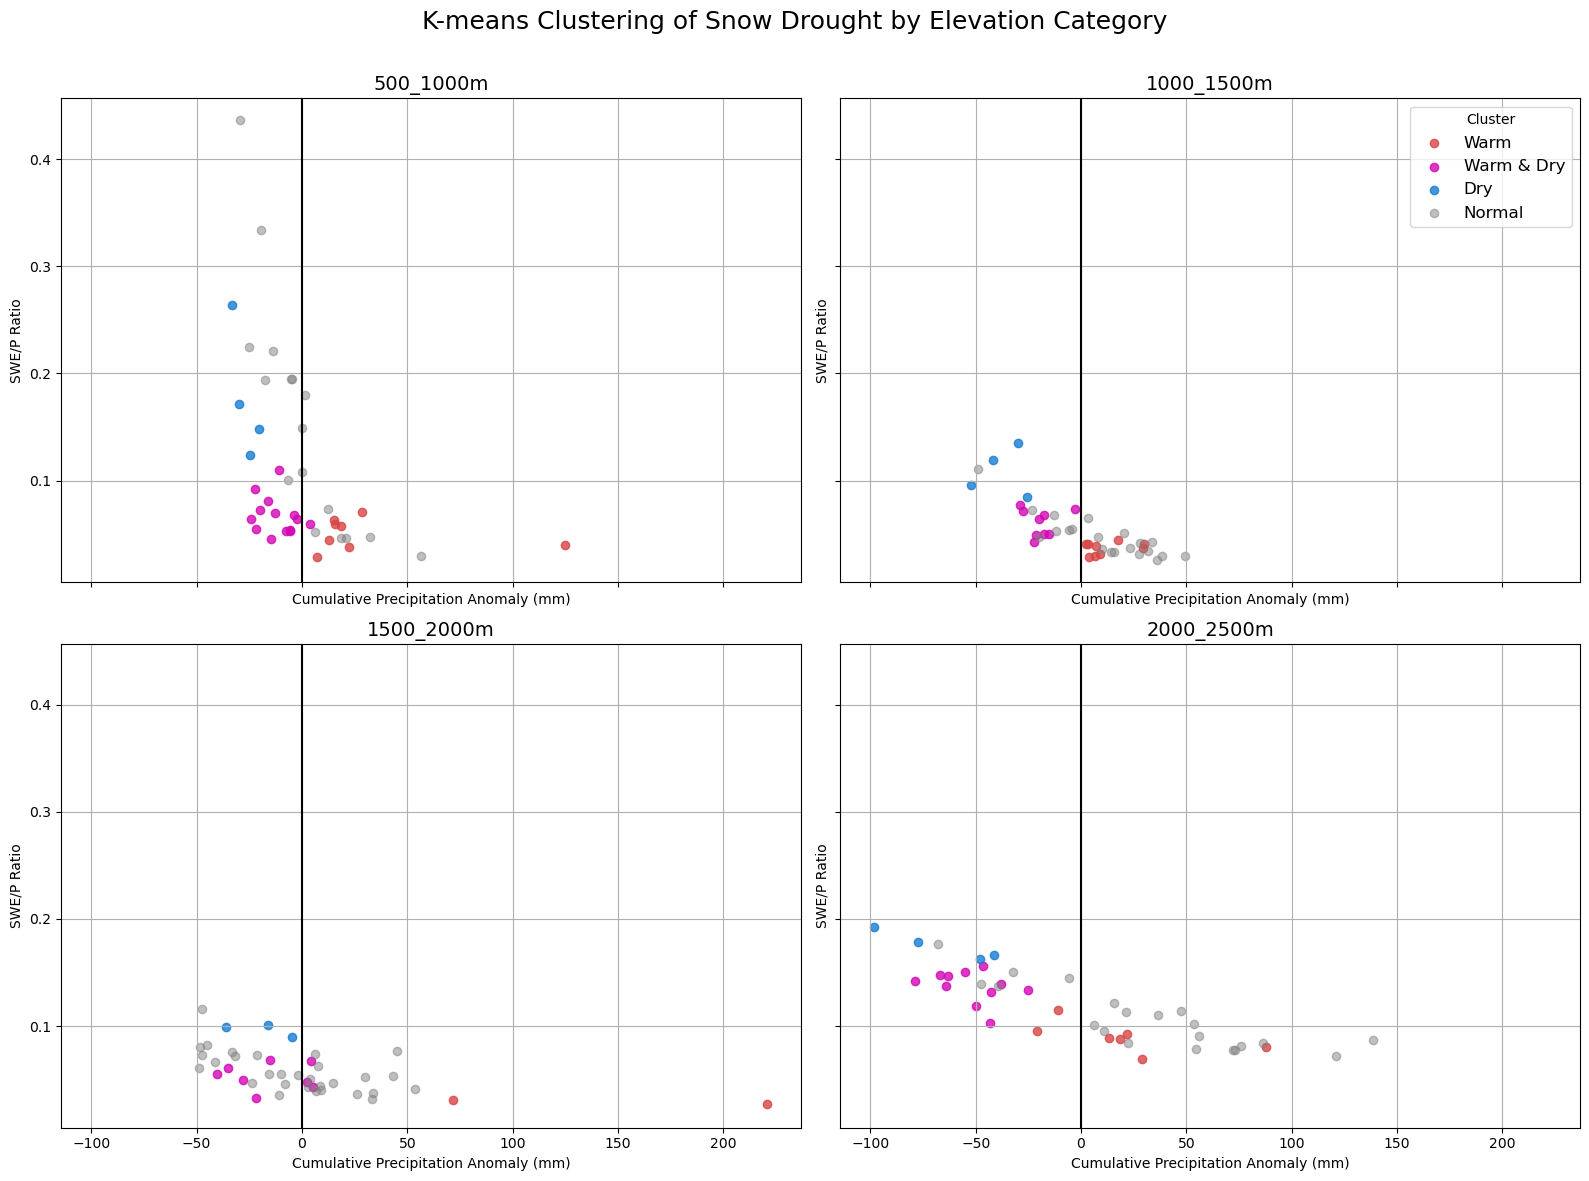

In [20]:
# Define cluster colors for plotting
cluster_colors = {
    "Warm": "#D84545",         # orange
    "Warm & Dry": "#D307B4",   # reddish
    "Dry": "#177DD1",          # blue
    # Add more cluster names and colors as needed
}

# Map cluster numbers to cluster names
cluster_number_to_name = {0: "Dry", 1: "Warm", 2:  "Warm & Dry"}
drought_years['cluster_name'] = drought_years['cluster'].map(cluster_number_to_name)

# Create subplots for each elevation category
elevations = drought_years['Elevation_Category'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, elev in enumerate(elevations):
    ax = axes[i]
    drought_subset = drought_years[drought_years['Elevation_Category'] == elev]
    non_drought_subset = non_drought_years[non_drought_years['Elevation_Category'] == elev]

    # Plot drought years with clusters
    for cname, color in cluster_colors.items():
        cluster_points = drought_subset[drought_subset['cluster_name'] == cname]
        ax.scatter(
            cluster_points['cumulative_P_anomaly'],
            cluster_points['mean_SWE/max_cumulative_P'],
            color=color,
            label=cname if i == 0 else "",  # Only label once for legend
            alpha=0.8
        )
    # Plot non-drought years
    ax.scatter(
        non_drought_subset['cumulative_P_anomaly'],
        non_drought_subset['mean_SWE/max_cumulative_P'],
        color='grey',
        label='Normal' if i == 0 else "",
        alpha=0.5
    )
    # Annotate drought years
    #for _, row in drought_subset.iterrows():
    #    ax.annotate(int(row['Season_year']), (row['cumulative_P_anomaly'], row['mean_SWE/max_cumulative_P']), fontsize=8, color='black', alpha=0.7)
    ax.axvline(0, color='black', linewidth=1.5, linestyle='-')
    ax.set_title(f'{elev}', fontsize=14)
    ax.set_xlabel('Cumulative Precipitation Anomaly (mm)')
    ax.set_ylabel('SWE/P Ratio')
    ax.grid(True)

# Add legend to the first subplot only
handles, labels = axes[0].get_legend_handles_labels()
# Place legend inside the top right subplot (axes[1])
axes[1].legend(handles, labels, title='Cluster', loc='upper right', fontsize=12)
plt.suptitle('K-means Clustering of Snow Drought by Elevation Category', fontsize=18)
#plt.ylim(0,0.6)
plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig(output_path + 'K-means_Clustering_Subplots_by_Elevation.png')
plt.show()

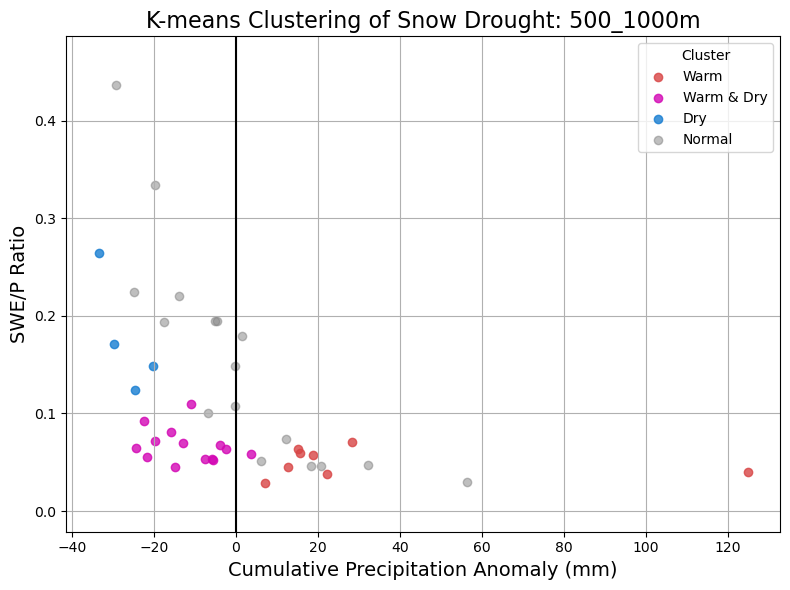

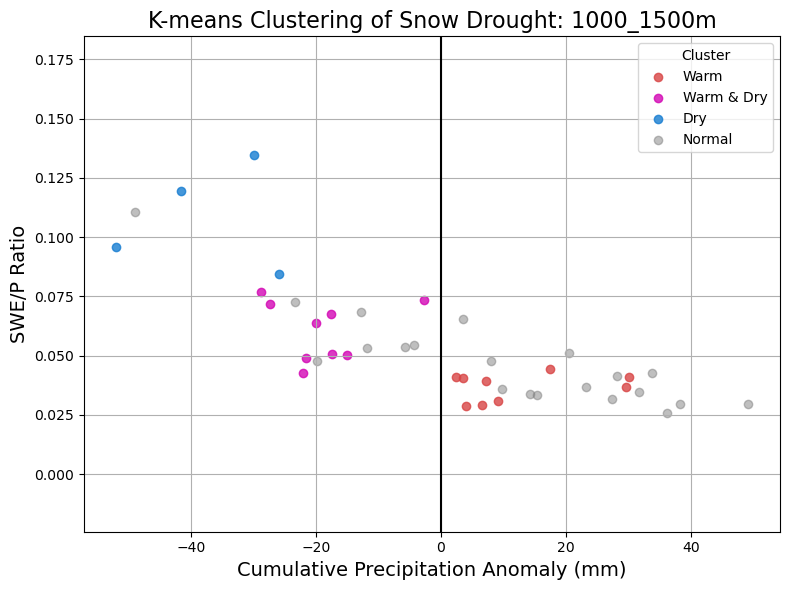

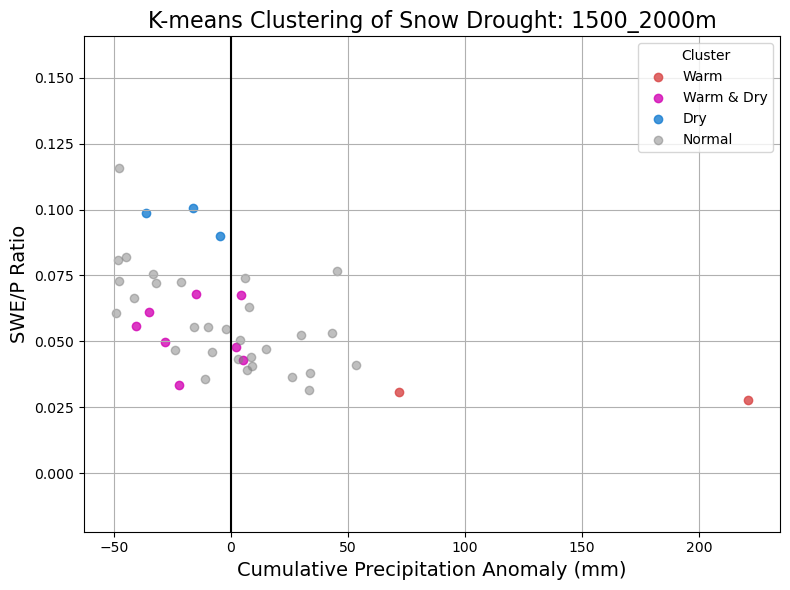

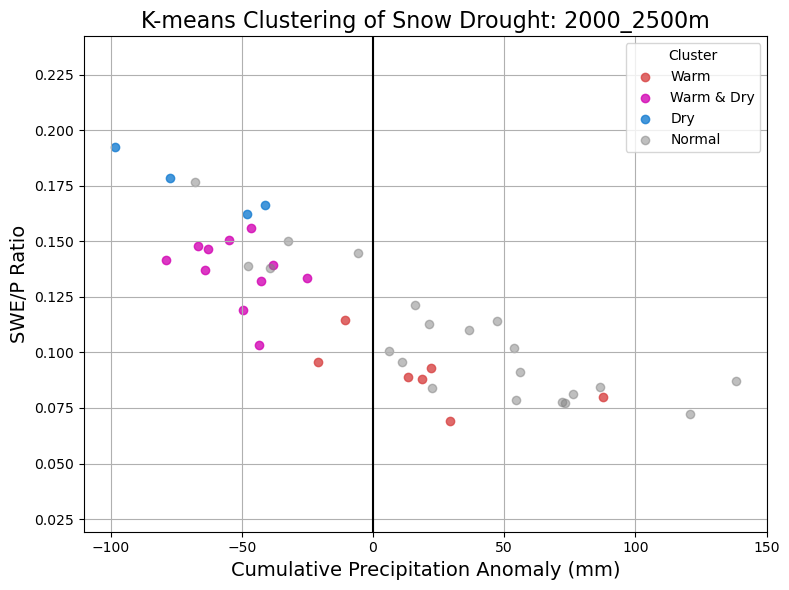

In [21]:
# Plot K-means clustering for snow drought years separately for each elevation category

elevations = drought_years['Elevation_Category'].unique()
cluster_colors = {
    "Warm": "#D84545",
    "Warm & Dry": "#D307B4",
    "Dry": "#177DD1",
}
cluster_number_to_name = {0: "Dry", 1: "Warm", 2:  "Warm & Dry"}

for elev in elevations:
    plt.figure(figsize=(8, 6))
    drought_subset = drought_years[drought_years['Elevation_Category'] == elev]
    non_drought_subset = non_drought_years[non_drought_years['Elevation_Category'] == elev]

    # Plot drought years with clusters
    for cname, color in cluster_colors.items():
        cluster_points = drought_subset[drought_subset['cluster_name'] == cname]
        plt.scatter(
            cluster_points['cumulative_P_anomaly'],
            cluster_points['mean_SWE/max_cumulative_P'],
            color=color,
            label=cname,
            alpha=0.8
        )
    # Plot non-drought years
    plt.scatter(
        non_drought_subset['cumulative_P_anomaly'],
        non_drought_subset['mean_SWE/max_cumulative_P'],
        color='grey',
        label='Normal',
        alpha=0.5
    )
    plt.axvline(0, color='black', linewidth=1.5, linestyle='-')
    plt.title(f'K-means Clustering of Snow Drought: {elev}', fontsize=16)
    plt.xlabel('Cumulative Precipitation Anomaly (mm)', fontsize=14)
    plt.ylabel('SWE/P Ratio', fontsize=14)
    plt.grid(True)
    plt.legend(title='Cluster')
    # Set y-axis limits based on data range for better visualization
    y_min = min(
        drought_subset['mean_SWE/max_cumulative_P'].min(),
        non_drought_subset['mean_SWE/max_cumulative_P'].min()
    )
    y_max = max(
        drought_subset['mean_SWE/max_cumulative_P'].max(),
        non_drought_subset['mean_SWE/max_cumulative_P'].max()
    )
    plt.ylim(y_min - 0.05, y_max + 0.05)
    plt.tight_layout()
    #plt.savefig(f"{output_path}K-means_Clustering_{elev.replace('/', '_')}.png")
    plt.show()

## 11. Summary

In this notebook, we've demonstrated the drought classification workflow for the Snow Drought Index package. We've loaded SSWEI data, classified drought conditions using both default and custom thresholds, analyzed drought characteristics, visualized drought patterns, and examined drought trends over time.

The workflow uses the following key functions from the `drought_classification` module:
- `classify_drought()` for classifying drought conditions based on SSWEI values
- `calculate_drought_characteristics()` for analyzing drought events
- `analyze_drought_trends()` for examining changes in drought patterns over time
- Various plotting functions for visualizing drought classifications and characteristics

These functions provide a comprehensive toolkit for analyzing drought conditions based on SSWEI data, enabling researchers to better understand drought patterns, severity, and trends over time.